In [2]:
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from zipfile import ZipFile

Fetch of the Kaggle Cats vs Dogs dataset


In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   223M      0  0:00:03  0:00:03 --:--:--  223M


In [4]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [5]:
!ls PetImages

Cat  Dog


Coding of the convolutional neural network from scratch following the code example from keras.io

In [6]:
#Delete corrupted images
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # we are removing the corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [7]:
#images Validation & distribution
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


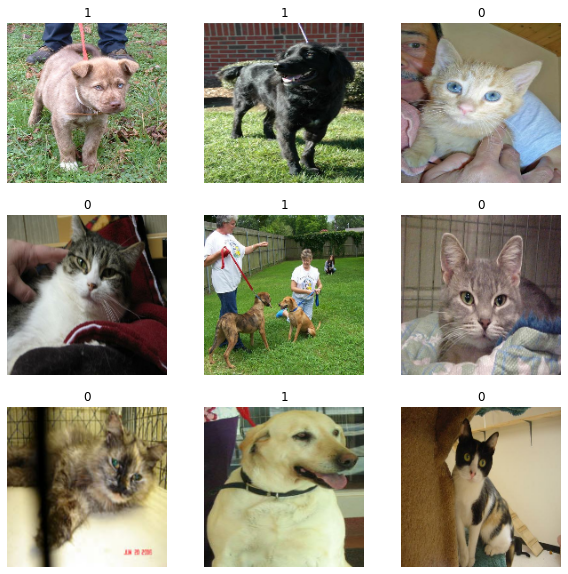

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9): #running the loop
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

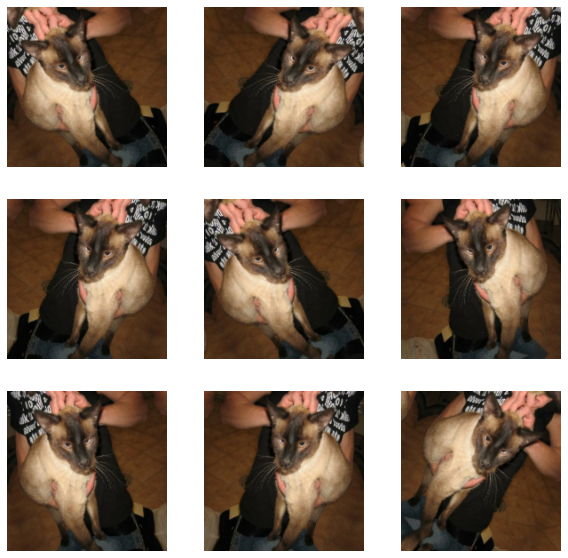

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

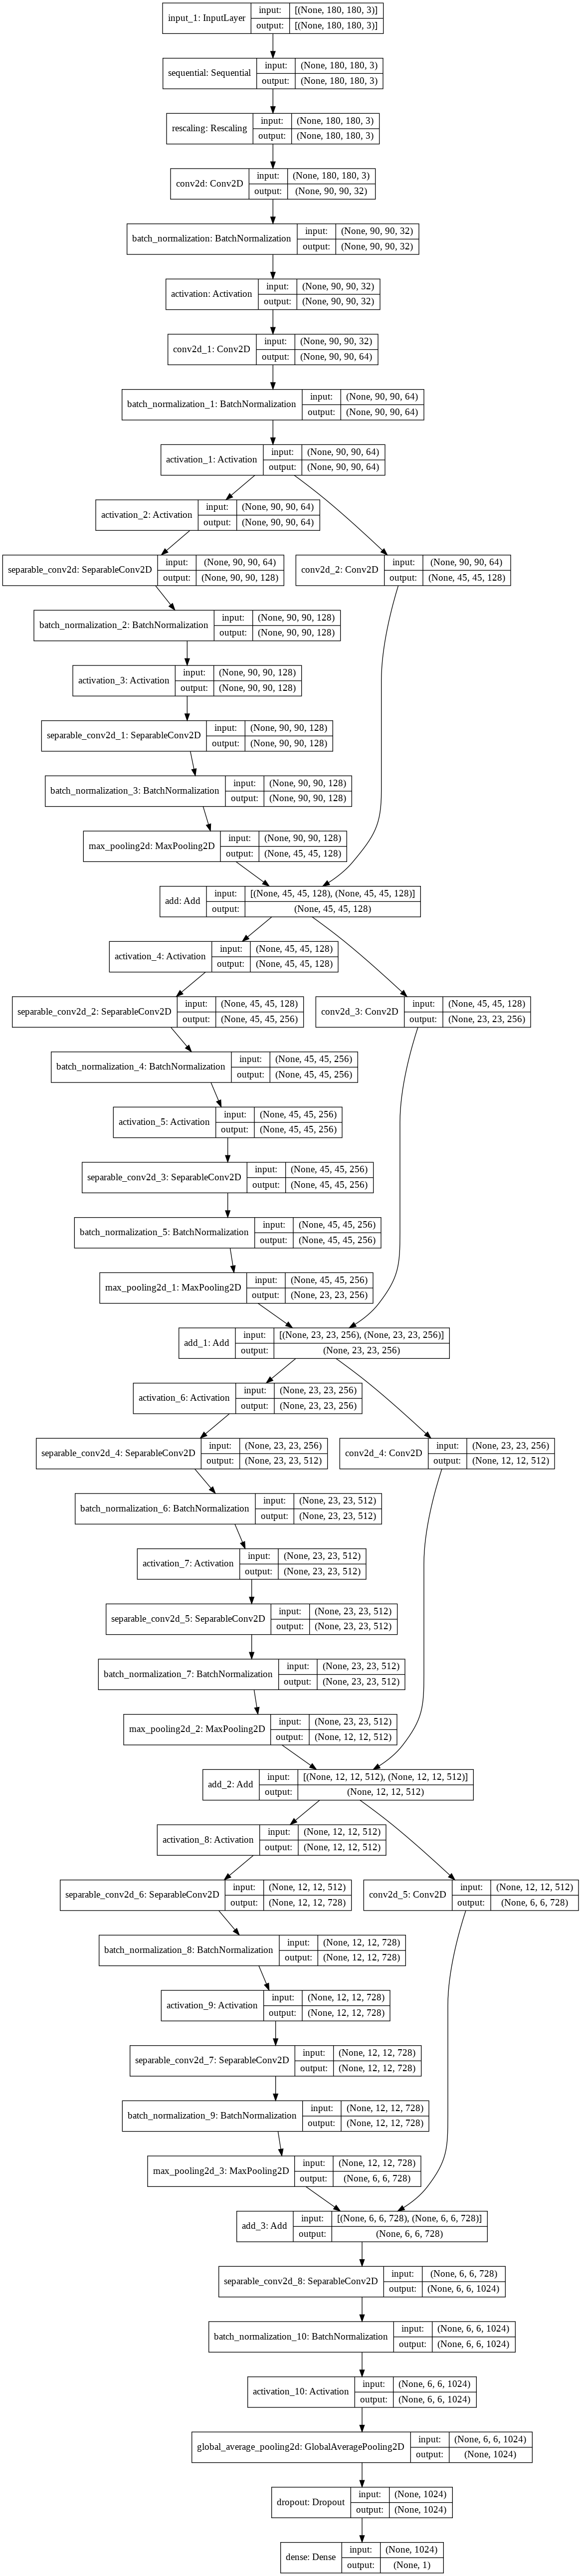

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # augmenting the image block
    x = data_augmentation(inputs)

    # Intial block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Creating the model using neural networks
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Adding residual
        previous_block_activation = x  # Setting aside the following residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
586/586 [==============================] - 129s 187ms/step - loss: 0.6440 - accuracy: 0.6427 - val_loss: 1.8855 - val_accuracy: 0.4962


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
586/586 [==============================] - 109s 186ms/step - loss: 0.4400 - accuracy: 0.7912 - val_loss: 0.4289 - val_accuracy: 0.8293
Epoch 3/25
586/586 [==============================] - 109s 186ms/step - loss: 0.3352 - accuracy: 0.8503 - val_loss: 0.2705 - val_accuracy: 0.8840
Epoch 4/25
586/586 [==============================] - 109s 186ms/step - loss: 0.2717 - accuracy: 0.8817 - val_loss: 0.2327 - val_accuracy: 0.9003
Epoch 5/25
586/586 [==============================] - 109s 186ms/step - loss: 0.2345 - accuracy: 0.9006 - val_loss: 0.3228 - val_accuracy: 0.8644
Epoch 6/25
586/586 [==============================] - 109s 186ms/step - loss: 0.2067 - accuracy: 0.9137 - val_loss: 0.5916 - val_accuracy: 0.7548
Epoch 7/25
586/586 [==============================] - 109s 186ms/step - loss: 0.1919 - accuracy: 0.9198 - val_loss: 0.2084 - val_accuracy: 0.9120
Epoch 8/25
586/586 [==============================] - 109s 186ms/step - loss: 0.1786 - accuracy: 0.9251 - val_loss: 0.2901 -

In [15]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 111s 186ms/step - loss: 0.0908 - accuracy: 0.9637 - val_loss: 0.1793 - val_accuracy: 0.9274


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
586/586 [==============================] - 109s 185ms/step - loss: 0.0877 - accuracy: 0.9661 - val_loss: 0.1235 - val_accuracy: 0.9554
Epoch 3/50
586/586 [==============================] - 109s 185ms/step - loss: 0.0855 - accuracy: 0.9646 - val_loss: 0.1010 - val_accuracy: 0.9613
Epoch 4/50
586/586 [==============================] - 109s 186ms/step - loss: 0.0776 - accuracy: 0.9681 - val_loss: 0.1078 - val_accuracy: 0.9626
Epoch 5/50
586/586 [==============================] - 109s 185ms/step - loss: 0.0788 - accuracy: 0.9683 - val_loss: 0.1523 - val_accuracy: 0.9460
Epoch 6/50
586/586 [==============================] - 109s 185ms/step - loss: 0.0803 - accuracy: 0.9674 - val_loss: 0.2031 - val_accuracy: 0.9227
Epoch 7/50
586/586 [==============================] - 109s 186ms/step - loss: 0.0764 - accuracy: 0.9702 - val_loss: 0.1174 - val_accuracy: 0.9562
Epoch 8/50
586/586 [==============================] - 109s 185ms/step - loss: 0.0737 - accuracy: 0.9711 - val_loss: 0.1037 -

Code an option that prompts the user for an image online (user to write the full URL of an image)

In [28]:
img_url = input("Enter the url: ")

Enter the url: https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/single-minded-royalty-free-image-997141470-1558379890.jpg


In [29]:
# loading image from url
from IPython.display import Image
img =Image(url= img_url , width=400, height=400)
img

Run your predictor model in the image from the URL submitted by the user and provide the best classification of whether the image is a dog or a cat. (30%)

In [46]:
import PIL.Image
from PIL import Image

In [58]:
from keras.preprocessing import image
test_image =image.load_img('/content/test.jpg',target_size =(180,180))
test_image =image.img_to_array(test_image)
test_image =np.expand_dims(test_image, axis =0)

result = model.predict(test_image)
if result[0][0] >= 0.5:
    prediction = 'dog'
else:
    prediction = 'cat'
print(prediction)

dog


# Feedback from Professor Sanchez

You did all of this work not to show the certainty values of your prediction?????   How certain was your model ?    